# Bert 

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create directory for saving results
os.makedirs("visualization", exist_ok=True)


/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-30 15:14:12.341958: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 15:14:12.343258: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 15:14:12.368603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriat

## Step 1: Data Loading

In [2]:
# Define NSL-KDD column names
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load dataset
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

# Drop difficulty degree (not useful)
train.drop("difficulty_degree", axis=1, inplace=True)
test.drop("difficulty_degree", axis=1, inplace=True)

# Convert categorical features to string representation
categorical_features = ["protocol_type", "service", "flag"]
for col in categorical_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

# Convert labels into binary classification
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)


In [3]:
def convert_to_text(row):
    return f"Duration: {row['duration']}, Protocol: {row['protocol_type']}, " \
           f"Service: {row['service']}, Flag: {row['flag']}, " \
           f"Src_Bytes: {row['src_bytes']}, Dst_Bytes: {row['dst_bytes']}, " \
           f"Count: {row['count']}, Serror_Rate: {row['serror_rate']}"

# Apply text conversion
train["text_features"] = train.apply(convert_to_text, axis=1)
test["text_features"] = test.apply(convert_to_text, axis=1)

# Split train/test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train["text_features"], train["labels"], test_size=0.2, random_state=42
)

# Convert to HuggingFace Dataset format
train_data = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_data = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})


In [4]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)


Map: 100%|██████████| 25195/25195 [00:06<00:00, 4121.30 examples/s]


In [5]:
# Load pre-trained BERT for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  1%|▏         | 500/37794 [02:36<3:16:53,  3.16it/s]

{'loss': 0.2046, 'grad_norm': 18.84813117980957, 'learning_rate': 1.973540773667778e-05, 'epoch': 0.04}


  3%|▎         | 1000/37794 [05:14<3:13:38,  3.17it/s]

{'loss': 0.0706, 'grad_norm': 0.07538463175296783, 'learning_rate': 1.947081547335556e-05, 'epoch': 0.08}


  4%|▍         | 1500/37794 [07:52<3:09:46,  3.19it/s]

{'loss': 0.0608, 'grad_norm': 0.005100916605442762, 'learning_rate': 1.920622321003334e-05, 'epoch': 0.12}


  5%|▌         | 2000/37794 [10:31<3:08:15,  3.17it/s]

{'loss': 0.0484, 'grad_norm': 15.900476455688477, 'learning_rate': 1.894163094671112e-05, 'epoch': 0.16}


  7%|▋         | 2500/37794 [13:11<3:08:41,  3.12it/s]

{'loss': 0.0469, 'grad_norm': 0.045207589864730835, 'learning_rate': 1.86770386833889e-05, 'epoch': 0.2}


  8%|▊         | 3000/37794 [15:48<3:02:54,  3.17it/s]

{'loss': 0.0386, 'grad_norm': 0.14993475377559662, 'learning_rate': 1.8412446420066677e-05, 'epoch': 0.24}


  9%|▉         | 3500/37794 [18:27<3:00:45,  3.16it/s]

{'loss': 0.042, 'grad_norm': 0.03529811277985573, 'learning_rate': 1.8147854156744457e-05, 'epoch': 0.28}


 11%|█         | 4000/37794 [21:05<2:54:32,  3.23it/s]

{'loss': 0.0474, 'grad_norm': 0.09096425026655197, 'learning_rate': 1.7883261893422237e-05, 'epoch': 0.32}


 12%|█▏        | 4500/37794 [26:18<5:48:45,  1.59it/s]

{'loss': 0.0342, 'grad_norm': 0.004226160701364279, 'learning_rate': 1.7618669630100017e-05, 'epoch': 0.36}


 13%|█▎        | 5000/37794 [31:34<5:44:15,  1.59it/s]

{'loss': 0.0393, 'grad_norm': 0.09982868283987045, 'learning_rate': 1.7354077366777796e-05, 'epoch': 0.4}


 15%|█▍        | 5500/37794 [36:50<5:39:19,  1.59it/s]

{'loss': 0.0339, 'grad_norm': 0.006996911950409412, 'learning_rate': 1.7089485103455576e-05, 'epoch': 0.44}


 16%|█▌        | 6000/37794 [42:06<5:35:38,  1.58it/s]

{'loss': 0.0232, 'grad_norm': 0.0029824357479810715, 'learning_rate': 1.6824892840133356e-05, 'epoch': 0.48}


 17%|█▋        | 6500/37794 [47:21<5:29:35,  1.58it/s]

{'loss': 0.0332, 'grad_norm': 0.003630196675658226, 'learning_rate': 1.6560300576811136e-05, 'epoch': 0.52}


 19%|█▊        | 7000/37794 [52:37<5:22:43,  1.59it/s]

{'loss': 0.0375, 'grad_norm': 0.03089498169720173, 'learning_rate': 1.6295708313488916e-05, 'epoch': 0.56}


 20%|█▉        | 7500/37794 [57:52<5:18:51,  1.58it/s]

{'loss': 0.0186, 'grad_norm': 0.018115602433681488, 'learning_rate': 1.6031116050166695e-05, 'epoch': 0.6}


 21%|██        | 8000/37794 [1:03:07<5:14:32,  1.58it/s]

{'loss': 0.0278, 'grad_norm': 0.008637674152851105, 'learning_rate': 1.5766523786844475e-05, 'epoch': 0.64}


 22%|██▏       | 8500/37794 [1:08:23<5:09:40,  1.58it/s]

{'loss': 0.0226, 'grad_norm': 0.00954483076930046, 'learning_rate': 1.5501931523522255e-05, 'epoch': 0.67}


 24%|██▍       | 9000/37794 [1:13:38<5:02:17,  1.59it/s]

{'loss': 0.0171, 'grad_norm': 0.027874287217855453, 'learning_rate': 1.5237339260200033e-05, 'epoch': 0.71}


 25%|██▌       | 9500/37794 [1:18:54<4:59:02,  1.58it/s]

{'loss': 0.0153, 'grad_norm': 0.009371873922646046, 'learning_rate': 1.4972746996877811e-05, 'epoch': 0.75}


 26%|██▋       | 10000/37794 [1:24:10<4:54:12,  1.57it/s]

{'loss': 0.0214, 'grad_norm': 0.009743419475853443, 'learning_rate': 1.4708154733555593e-05, 'epoch': 0.79}


 28%|██▊       | 10500/37794 [1:29:24<4:44:09,  1.60it/s]

{'loss': 0.01, 'grad_norm': 0.001548753585666418, 'learning_rate': 1.4443562470233373e-05, 'epoch': 0.83}


 29%|██▉       | 11000/37794 [1:34:39<4:43:09,  1.58it/s]

{'loss': 0.0284, 'grad_norm': 0.003495429642498493, 'learning_rate': 1.417897020691115e-05, 'epoch': 0.87}


 30%|███       | 11500/37794 [1:39:53<4:37:10,  1.58it/s]

{'loss': 0.0215, 'grad_norm': 0.0039984616450965405, 'learning_rate': 1.391437794358893e-05, 'epoch': 0.91}


 32%|███▏      | 12000/37794 [1:45:07<4:29:41,  1.59it/s]

{'loss': 0.0189, 'grad_norm': 0.0010824607452377677, 'learning_rate': 1.364978568026671e-05, 'epoch': 0.95}


 33%|███▎      | 12500/37794 [1:50:21<4:24:27,  1.59it/s]

{'loss': 0.0171, 'grad_norm': 0.0022133933380246162, 'learning_rate': 1.3385193416944488e-05, 'epoch': 0.99}


                                                         
 33%|███▎      | 12598/37794 [2:00:56<3:33:12,  1.97it/s]

{'eval_loss': 0.02163275144994259, 'eval_runtime': 573.2751, 'eval_samples_per_second': 43.949, 'eval_steps_per_second': 5.495, 'epoch': 1.0}


 34%|███▍      | 13000/37794 [2:05:10<4:21:22,  1.58it/s]    

{'loss': 0.0156, 'grad_norm': 0.0012903843307867646, 'learning_rate': 1.312060115362227e-05, 'epoch': 1.03}


 36%|███▌      | 13500/37794 [2:10:24<4:13:43,  1.60it/s]

{'loss': 0.0103, 'grad_norm': 0.0011861494276672602, 'learning_rate': 1.285600889030005e-05, 'epoch': 1.07}


 37%|███▋      | 14000/37794 [2:15:38<4:10:35,  1.58it/s]

{'loss': 0.036, 'grad_norm': 0.006628215778619051, 'learning_rate': 1.2591416626977828e-05, 'epoch': 1.11}


 38%|███▊      | 14500/37794 [2:20:52<4:01:52,  1.61it/s]

{'loss': 0.0134, 'grad_norm': 0.003987455740571022, 'learning_rate': 1.2326824363655608e-05, 'epoch': 1.15}


 40%|███▉      | 15000/37794 [2:26:06<4:00:07,  1.58it/s]

{'loss': 0.0213, 'grad_norm': 0.0022478927858173847, 'learning_rate': 1.2062232100333386e-05, 'epoch': 1.19}


 41%|████      | 15500/37794 [2:31:20<3:53:33,  1.59it/s]

{'loss': 0.0184, 'grad_norm': 0.033156927675008774, 'learning_rate': 1.1797639837011167e-05, 'epoch': 1.23}


 42%|████▏     | 16000/37794 [2:36:34<3:49:19,  1.58it/s]

{'loss': 0.0135, 'grad_norm': 0.06821487843990326, 'learning_rate': 1.1533047573688947e-05, 'epoch': 1.27}


 44%|████▎     | 16500/37794 [2:41:48<3:42:10,  1.60it/s]

{'loss': 0.011, 'grad_norm': 0.004748570267111063, 'learning_rate': 1.1268455310366727e-05, 'epoch': 1.31}


 45%|████▍     | 17000/37794 [2:47:03<3:36:56,  1.60it/s]

{'loss': 0.019, 'grad_norm': 0.0016772543312981725, 'learning_rate': 1.1003863047044505e-05, 'epoch': 1.35}


 46%|████▋     | 17500/37794 [2:52:17<3:32:26,  1.59it/s]

{'loss': 0.017, 'grad_norm': 0.0009120458853431046, 'learning_rate': 1.0739270783722285e-05, 'epoch': 1.39}


 48%|████▊     | 18000/37794 [2:57:32<3:28:41,  1.58it/s]

{'loss': 0.0203, 'grad_norm': 0.008915522135794163, 'learning_rate': 1.0474678520400063e-05, 'epoch': 1.43}


 49%|████▉     | 18500/37794 [3:02:46<3:23:01,  1.58it/s]

{'loss': 0.0141, 'grad_norm': 0.034767355769872665, 'learning_rate': 1.0210086257077844e-05, 'epoch': 1.47}


 50%|█████     | 19000/37794 [3:08:00<3:16:58,  1.59it/s]

{'loss': 0.0166, 'grad_norm': 0.0005738725885748863, 'learning_rate': 9.945493993755624e-06, 'epoch': 1.51}


 52%|█████▏    | 19500/37794 [3:13:14<3:10:59,  1.60it/s]

{'loss': 0.0162, 'grad_norm': 0.0031972501892596483, 'learning_rate': 9.680901730433402e-06, 'epoch': 1.55}


 53%|█████▎    | 20000/37794 [3:18:28<3:07:02,  1.59it/s]

{'loss': 0.0104, 'grad_norm': 0.0009750436875037849, 'learning_rate': 9.416309467111182e-06, 'epoch': 1.59}


 54%|█████▍    | 20500/37794 [3:23:42<3:00:27,  1.60it/s]

{'loss': 0.0206, 'grad_norm': 0.005801619030535221, 'learning_rate': 9.151717203788962e-06, 'epoch': 1.63}


 56%|█████▌    | 21000/37794 [3:28:56<2:56:22,  1.59it/s]

{'loss': 0.0132, 'grad_norm': 0.0013414626009762287, 'learning_rate': 8.887124940466742e-06, 'epoch': 1.67}


 57%|█████▋    | 21500/37794 [3:34:10<2:49:53,  1.60it/s]

{'loss': 0.0088, 'grad_norm': 0.0022291617933660746, 'learning_rate': 8.62253267714452e-06, 'epoch': 1.71}


 58%|█████▊    | 22000/37794 [3:39:25<2:45:47,  1.59it/s]

{'loss': 0.0141, 'grad_norm': 0.005001650657504797, 'learning_rate': 8.357940413822301e-06, 'epoch': 1.75}


 60%|█████▉    | 22500/37794 [3:44:42<2:44:43,  1.55it/s]

{'loss': 0.0148, 'grad_norm': 0.008253064937889576, 'learning_rate': 8.09334815050008e-06, 'epoch': 1.79}


 61%|██████    | 23000/37794 [3:50:06<2:38:42,  1.55it/s]

{'loss': 0.0092, 'grad_norm': 0.005913350265473127, 'learning_rate': 7.82875588717786e-06, 'epoch': 1.83}


 62%|██████▏   | 23500/37794 [3:55:29<2:34:47,  1.54it/s]

{'loss': 0.0105, 'grad_norm': 0.0025087427347898483, 'learning_rate': 7.564163623855639e-06, 'epoch': 1.87}


 64%|██████▎   | 24000/37794 [4:00:54<2:28:50,  1.54it/s]

{'loss': 0.0162, 'grad_norm': 0.004840192850679159, 'learning_rate': 7.299571360533419e-06, 'epoch': 1.91}


 65%|██████▍   | 24500/37794 [4:06:17<2:24:15,  1.54it/s]

{'loss': 0.014, 'grad_norm': 0.0038555157370865345, 'learning_rate': 7.034979097211199e-06, 'epoch': 1.94}


 66%|██████▌   | 25000/37794 [4:11:41<2:18:44,  1.54it/s]

{'loss': 0.0146, 'grad_norm': 0.012351340614259243, 'learning_rate': 6.770386833888978e-06, 'epoch': 1.98}


                                                         
 67%|██████▋   | 25196/37794 [4:23:23<1:50:01,  1.91it/s]

{'eval_loss': 0.01607639342546463, 'eval_runtime': 576.2553, 'eval_samples_per_second': 43.722, 'eval_steps_per_second': 5.466, 'epoch': 2.0}


 67%|██████▋   | 25500/37794 [4:26:27<2:02:49,  1.67it/s]   

{'loss': 0.0023, 'grad_norm': 0.00027068014605902135, 'learning_rate': 6.5057945705667566e-06, 'epoch': 2.02}


 69%|██████▉   | 26000/37794 [4:31:26<1:58:01,  1.67it/s]

{'loss': 0.0179, 'grad_norm': 0.004385930020362139, 'learning_rate': 6.241202307244537e-06, 'epoch': 2.06}


 70%|███████   | 26500/37794 [4:36:26<1:53:00,  1.67it/s]

{'loss': 0.0093, 'grad_norm': 0.00034186578704975545, 'learning_rate': 5.976610043922316e-06, 'epoch': 2.1}


 71%|███████▏  | 27000/37794 [4:41:26<1:47:20,  1.68it/s]

{'loss': 0.0025, 'grad_norm': 0.000552975689060986, 'learning_rate': 5.712017780600095e-06, 'epoch': 2.14}


 73%|███████▎  | 27500/37794 [4:46:25<1:43:09,  1.66it/s]

{'loss': 0.011, 'grad_norm': 0.002786650788038969, 'learning_rate': 5.447425517277876e-06, 'epoch': 2.18}


 74%|███████▍  | 28000/37794 [4:51:25<1:38:01,  1.67it/s]

{'loss': 0.0108, 'grad_norm': 0.000340334081556648, 'learning_rate': 5.182833253955655e-06, 'epoch': 2.22}


 75%|███████▌  | 28500/37794 [4:56:25<1:32:27,  1.68it/s]

{'loss': 0.0113, 'grad_norm': 0.004120755475014448, 'learning_rate': 4.9182409906334345e-06, 'epoch': 2.26}


 77%|███████▋  | 29000/37794 [5:01:24<1:27:54,  1.67it/s]

{'loss': 0.0078, 'grad_norm': 0.00033823587000370026, 'learning_rate': 4.6536487273112135e-06, 'epoch': 2.3}


 78%|███████▊  | 29500/37794 [5:06:24<1:22:43,  1.67it/s]

{'loss': 0.005, 'grad_norm': 0.0003592929570004344, 'learning_rate': 4.389056463988993e-06, 'epoch': 2.34}


 79%|███████▉  | 30000/37794 [5:11:24<1:17:48,  1.67it/s]

{'loss': 0.0162, 'grad_norm': 0.016014451161026955, 'learning_rate': 4.124464200666773e-06, 'epoch': 2.38}


 81%|████████  | 30500/37794 [5:16:23<1:12:58,  1.67it/s]

{'loss': 0.0053, 'grad_norm': 0.00019145965052302927, 'learning_rate': 3.859871937344553e-06, 'epoch': 2.42}


 82%|████████▏ | 31000/37794 [5:21:23<1:07:57,  1.67it/s]

{'loss': 0.0037, 'grad_norm': 0.00016748766938690096, 'learning_rate': 3.595279674022332e-06, 'epoch': 2.46}


 83%|████████▎ | 31500/37794 [5:26:22<1:02:45,  1.67it/s]

{'loss': 0.006, 'grad_norm': 0.001406886032782495, 'learning_rate': 3.3306874107001113e-06, 'epoch': 2.5}


 85%|████████▍ | 32000/37794 [5:31:22<57:39,  1.67it/s]  

{'loss': 0.0149, 'grad_norm': 0.0089411037042737, 'learning_rate': 3.066095147377891e-06, 'epoch': 2.54}


 86%|████████▌ | 32500/37794 [5:36:22<53:05,  1.66it/s]

{'loss': 0.0062, 'grad_norm': 0.050883229821920395, 'learning_rate': 2.80150288405567e-06, 'epoch': 2.58}


 87%|████████▋ | 33000/37794 [5:41:21<48:07,  1.66it/s]

{'loss': 0.0052, 'grad_norm': 0.006300165317952633, 'learning_rate': 2.53691062073345e-06, 'epoch': 2.62}


 89%|████████▊ | 33500/37794 [5:46:21<42:56,  1.67it/s]

{'loss': 0.0079, 'grad_norm': 0.0011167085031047463, 'learning_rate': 2.2723183574112297e-06, 'epoch': 2.66}


 90%|████████▉ | 34000/37794 [5:51:21<37:54,  1.67it/s]

{'loss': 0.0066, 'grad_norm': 0.03677203878760338, 'learning_rate': 2.007726094089009e-06, 'epoch': 2.7}


 91%|█████████▏| 34500/37794 [5:56:20<32:49,  1.67it/s]

{'loss': 0.0081, 'grad_norm': 0.0035055293701589108, 'learning_rate': 1.7431338307667886e-06, 'epoch': 2.74}


 93%|█████████▎| 35000/37794 [6:01:20<27:50,  1.67it/s]

{'loss': 0.0104, 'grad_norm': 0.016214745119214058, 'learning_rate': 1.478541567444568e-06, 'epoch': 2.78}


 94%|█████████▍| 35500/37794 [6:06:20<22:58,  1.66it/s]

{'loss': 0.0051, 'grad_norm': 0.001806454500183463, 'learning_rate': 1.2139493041223476e-06, 'epoch': 2.82}


 95%|█████████▌| 36000/37794 [6:11:19<17:55,  1.67it/s]

{'loss': 0.0046, 'grad_norm': 0.0021482123993337154, 'learning_rate': 9.493570408001271e-07, 'epoch': 2.86}


 97%|█████████▋| 36500/37794 [6:16:14<13:25,  1.61it/s]

{'loss': 0.0081, 'grad_norm': 0.0002148152852896601, 'learning_rate': 6.847647774779066e-07, 'epoch': 2.9}


 98%|█████████▊| 37000/37794 [6:21:37<08:29,  1.56it/s]

{'loss': 0.0044, 'grad_norm': 0.004476460162550211, 'learning_rate': 4.201725141556861e-07, 'epoch': 2.94}


 99%|█████████▉| 37500/37794 [6:27:00<03:10,  1.54it/s]

{'loss': 0.0191, 'grad_norm': 0.002117086900398135, 'learning_rate': 1.5558025083346565e-07, 'epoch': 2.98}


                                                       
100%|██████████| 37794/37794 [6:39:55<00:00,  1.92it/s]

{'eval_loss': 0.01440094318240881, 'eval_runtime': 584.1448, 'eval_samples_per_second': 43.131, 'eval_steps_per_second': 5.392, 'epoch': 3.0}


100%|██████████| 37794/37794 [6:40:00<00:00,  1.57it/s]

{'train_runtime': 24000.1934, 'train_samples_per_second': 12.597, 'train_steps_per_second': 1.575, 'train_loss': 0.020949327627767324, 'epoch': 3.0}


TrainOutput(global_step=37794, training_loss=0.020949327627767324, metrics={'train_runtime': 24000.1934, 'train_samples_per_second': 12.597, 'train_steps_per_second': 1.575, 'total_flos': 7.954741781121024e+16, 'train_loss': 0.020949327627767324, 'epoch': 3.0})

In [6]:
# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation results: {results}")

# Make predictions
preds = trainer.predict(val_data)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = val_labels.tolist()


  0%|          | 0/3150 [00:00<?, ?it/s]

100%|██████████| 3150/3150 [09:41<00:00,  5.41it/s]


Evaluation results: {'eval_loss': 0.01440094318240881, 'eval_runtime': 581.8891, 'eval_samples_per_second': 43.299, 'eval_steps_per_second': 5.413, 'epoch': 3.0}


100%|██████████| 3150/3150 [09:21<00:00,  5.61it/s]


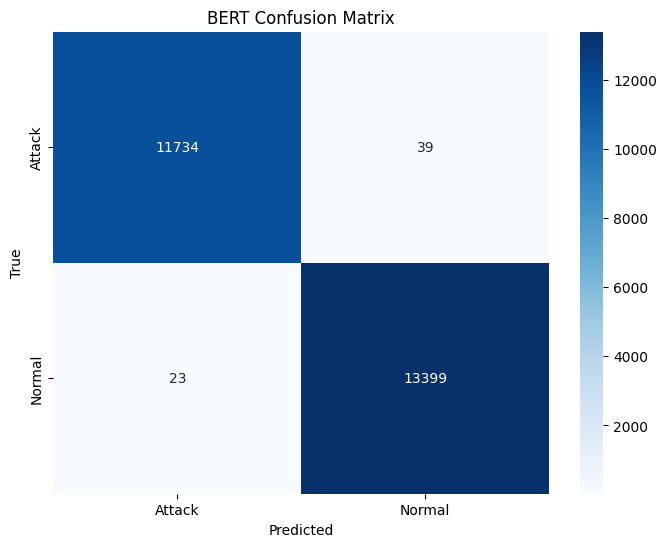

              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     11773
      Normal       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



In [7]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Attack", "Normal"]))


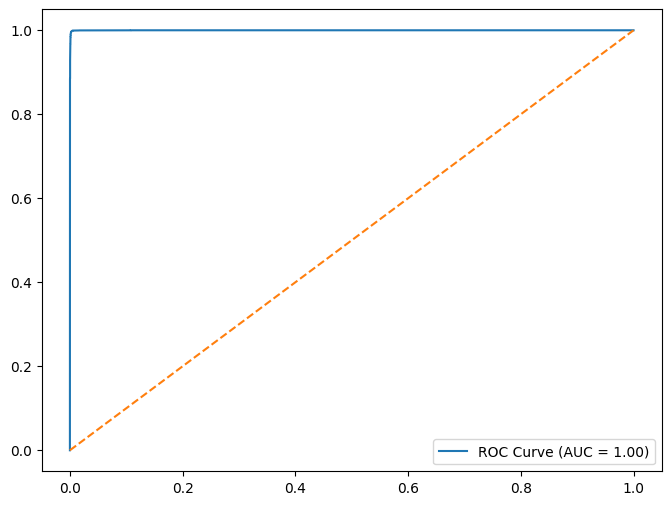

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, preds.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.legend()
plt.show()
